In [1]:
import numpy as np
from matplotlib import pyplot as plt
import MNISTtools
help(MNISTtools.load)
help(MNISTtools.show)

Help on function load in module MNISTtools:

load(dataset='training', path='.')
    Import either the training or testing MNIST data set.
    It returns a pair with the first element being the collection of
    images stacked in columns and the second element being a vector
    of corresponding labels from 0 to 9.
    
    Example:
        x, lbl = load(dataset = "training", path = "/datasets/MNIST")

Help on function show in module MNISTtools:

show(image)
    Render a given MNIST image provided as a column vector.
    
    Example:
        x, lbl = load(dataset = "training", path = "/datasets/MNIST")
        show(x[:, 0])



In [2]:
#1
xtrain, ltrain = MNISTtools.load(dataset = "training", path = "/datasets/MNIST")
# find the shape
print "xtrain shpae:",xtrain.shape 
print "ltrain shape:",ltrain.shape
# find the size
print"xtrain:", xtrain.size
print"ltrain:", ltrain.size
print "Dimension of the feature is 2"

xtrain shpae: (784, 60000)
ltrain shape: (60000,)
xtrain: 47040000
ltrain: 60000
Dimension of the feature is 2


Index 42: 7


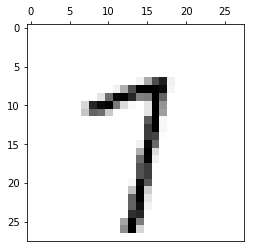

In [3]:
#2
print "Index 42:", ltrain[42]
MNISTtools.show(xtrain[:,42])

In [4]:
#3
#find the max and min of xtrain
Max = xtrain.max()
Min = xtrain.min()
print "Range of xtrain is between", Min, "and", Max
# type of xtrain
print "Data type:", type(xtrain) 
print "element data type:", xtrain.dtype

Range of xtrain is between 0 and 255
Data type: <type 'numpy.ndarray'>
element data type: uint8


In [5]:
#4
def normalize_MNIST_images(x):
    m = x.min()
    M = x.max()
    x = x.astype(np.float64) # turn data from int to float
    x_res = 2*((x - m).astype(np.float64)/(M - m)) - 1 # normalize and do the minus 1
    return x_res
#update xtrain
xtrain = normalize_MNIST_images(xtrain)

In [6]:
#5 
def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size)) #reshape so that d will be 10 by 60000
    d[lbl, np.arange(0, lbl.size)] = 1 # set the index of ltrain number into 1
    return d
dtrain = label2onehot(ltrain)

In [7]:
#6
def onehot2label(d):
    lbl = d.argmax(axis=0)
    return lbl

In [8]:
#7
def softmax(a):
    Max = a.max(axis=0)
    return np.exp(a-Max) / np.sum(np.exp(a-Max), axis=0)

In [9]:
#10
def softmaxp(a, e):
    g = softmax(a)
    return g*e - np.sum(g*e, axis=0)*g

In [10]:
#11
eps = 1e-6 # finite difference step
a = np.random.randn(10, 200) # random inputs
e = np.random.randn(10, 200) # random directions
diff = softmaxp(a, e)
diff_approx = (softmax(a+e*eps) - softmax(a))/eps
rel_error = np.abs(diff - diff_approx).mean() / np.abs(diff_approx).mean()
print(rel_error, 'should be smaller than 1e-6')

(4.782510391814837e-07, 'should be smaller than 1e-6')


In [11]:
#12
def relu(a):
    a[(a<0)] = 0
    a[0] = 0
    return a
    
def relup(a, e):
    ret_a = np.zeros(a.shape)
    ret_a[(a>0)] = 1
    return ret_a*e
    

In [12]:
#13
def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.))
    return W1, b1, W2, b2
Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit = init_shallow(Ni, Nh, No)

In [13]:
#14
def forwardprop_shallow(x, net):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    
    a1 = W1.dot(x) + b1
    h1 = relu(a1)
    a2 = W2.dot(h1) + b2
    y = softmax(a2)
    
    return y
yinit = forwardprop_shallow(xtrain, netinit)

In [14]:
#15
def eval_loss(y, d):
    y = np.log(y)
    return -np.sum(d*y)/d.size
print(eval_loss(yinit, dtrain), 'should be around .26')


(0.23179920161367104, 'should be around .26')


In [15]:
#16
def eval_perfs(y, lbl):
    tmp = np.ones(lbl.shape)
    tmp[onehot2label(y)-lbl == 0] = 0
    #res = onehot2label(y)
    #tmp = lbl - res
    #tmp[tmp>0]=1
    #tmp[tmp<0]=1
    #tmp[tmp==0]=0
    return sum(tmp)*1.0/len(lbl)
print(eval_perfs(yinit, ltrain))

0.8476166666666667


In [16]:
#17
def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    
    
    a1 = W1.dot(x)
    h1 = relu(a1)
    a2 = W2.dot(h1)
    y = softmax(a2)
    e = -d/y
    delta2 = softmaxp(a2,e)
    delta1 = relup(a1,W2.T.dot(delta2))
    W2 = W2 - gamma * delta2.dot(h1.T)
    W1 = W1 - gamma * delta1.dot(x.T)
    b2 = b2 - gamma * delta2.sum(axis=1).reshape(No,1)
    b1 = b1 - gamma * delta1.sum(axis=1).reshape(Nh,1)
    
    return W1, b1, W2, b2

T =  100
train loss: 0.04690538035875485
train perfs: 0.1283


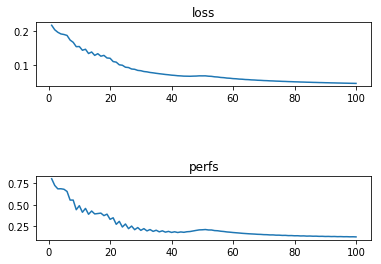

In [17]:
#18
print "T = ", 100
def backprop_shallow(x, d, net, T, gamma=.05):
    lbl = onehot2label(d)
    x_plot = np.arange(1,T+1).reshape(T,1)
    res_loss = []
    res_perfs = []
    for t in range(0, T):
        net = update_shallow(x, d, net, gamma)
        y = forwardprop_shallow(x,net)
        loss = eval_loss(y,d)        
        perfs = eval_perfs(y,lbl)
        res_loss.append(loss)
        res_perfs.append(perfs)
    plt.subplot(3,1,1)
    plt.plot(x_plot,res_loss)
    plt.title('loss')
    plt.show
    plt.subplot(3,1,3)
    plt.plot(x_plot,res_perfs)
    plt.title('perfs')
    plt.show
    print "train loss:", loss
    print "train perfs:", perfs    
    return net
nettrain = backprop_shallow(xtrain, dtrain, netinit, 100)

In [18]:
#19
xtest, ltest = MNISTtools.load(dataset = "testing", path = "/datasets/MNIST")
print "xtest size:", xtest.size
print "ltest size:", ltest.size
dtest = label2onehot(ltest)
xtest = normalize_MNIST_images(xtest)
y_resback = forwardprop_shallow(xtest, nettrain)
print "test loss:", eval_loss(y_resback, dtest)
print "test perfs:", eval_perfs(y_resback, onehot2label(dtest))

xtest size: 7840000
ltest size: 10000
test loss: 0.0449501469381865
test perfs: 0.1225


B =  100
train loss: 0.016489625291708658
train perfs: 0.050333333333333334


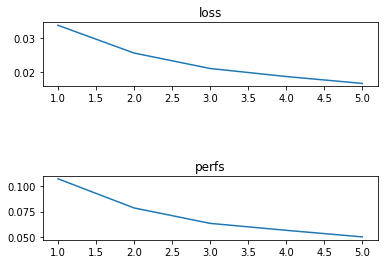

In [19]:
#20
print "B = ", 100
def backprop_minibatch_shallow(x, d, net, T, B=100, gamma=.05):
    N = x.shape[1]
    lbl = onehot2label(d)
    x_plot = np.arange(1,T+1).reshape(T,1)
    res_loss = []
    res_perfs = []
    for t in range(0, T):
        for l in range(0, (N+B-1)/B):
            idx = np.arange(B*l, min(B*(l+1), N))
            net = update_shallow(x[:,idx],d[:,idx],net,gamma)
        y = forwardprop_shallow(x, net)
        loss = eval_loss(y,d)        
        perfs = eval_perfs(y,lbl)
        res_loss.append(loss)
        res_perfs.append(perfs)    
    plt.subplot(3,1,1)
    plt.plot(x_plot,res_loss)
    plt.title('loss')
    plt.show
    plt.subplot(3,1,3)
    plt.plot(x_plot,res_perfs)
    plt.title('perfs')
    plt.show
    print "train loss:", loss
    print "train perfs:", perfs
    return net
netminibatch = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=100)


In [20]:
#21
y_resMini = forwardprop_shallow(xtest, netminibatch)
print "test loss:", eval_loss(y_resMini, dtest)
print "test perfs:", eval_perfs(y_resMini, onehot2label(dtest))

test loss: 0.01732212263955985
test perfs: 0.0526


Nh = 16:
train loss: 0.06573898037370009
train perfs: 0.19255
test loss: 0.06469078342714134
test perfs: 0.1893


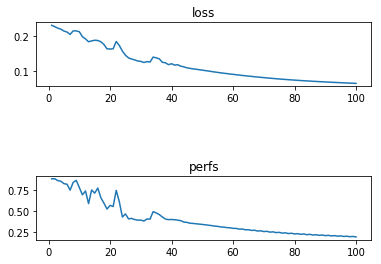

In [21]:
#22
Nh = 16
print "Nh = 16:"
netinit = init_shallow(Ni, Nh, No)
nettrain = backprop_shallow(xtrain, dtrain, netinit, 100)
y_resback = forwardprop_shallow(xtest, nettrain)
print "test loss:", eval_loss(y_resback, dtest)
print "test perfs:", eval_perfs(y_resback, onehot2label(dtest))

Nh = 256:
train loss: 0.04489123587899908
train perfs: 0.12823333333333334
test loss: 0.043059377193413545
test perfs: 0.1245


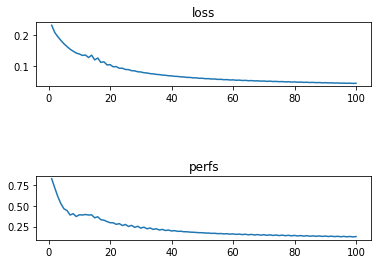

In [22]:
Nh = 256
print "Nh = 256:"
netinit = init_shallow(Ni, Nh, No)
nettrain = backprop_shallow(xtrain, dtrain, netinit, 100)
y_resback = forwardprop_shallow(xtest, nettrain)
print "test loss:", eval_loss(y_resback, dtest)
print "test perfs:", eval_perfs(y_resback, onehot2label(dtest))

gamma = 0.02:
train loss: 0.07224440026955989
train perfs: 0.18668333333333334
test loss: 0.06995530720928486
test perfs: 0.177


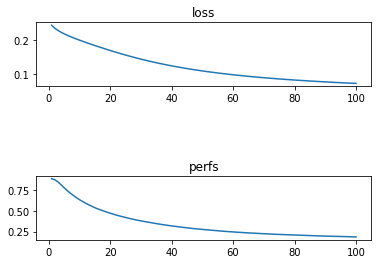

In [23]:
#23
Nh = 64
print "gamma = 0.02:"
netinit = init_shallow(Ni, Nh, No)
nettrain = backprop_shallow(xtrain, dtrain, netinit, 100, 0.02)
y_resback = forwardprop_shallow(xtest, nettrain)
print "test loss:", eval_loss(y_resback, dtest)
print "test perfs:", eval_perfs(y_resback, onehot2label(dtest))

gamma = 0.08:
train loss: 0.04243517651820795
train perfs: 0.11971666666666667
test loss: 0.040422411452002364
test perfs: 0.1136


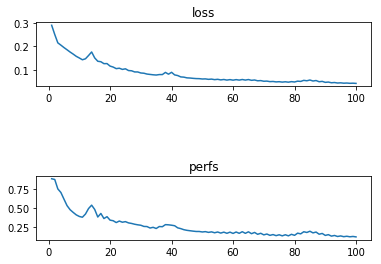

In [24]:
print "gamma = 0.08:"
nettrain = backprop_shallow(xtrain, dtrain, netinit, 100, 0.08)
y_resback = forwardprop_shallow(xtest, nettrain)
print "test loss:", eval_loss(y_resback, dtest)
print "test perfs:", eval_perfs(y_resback, onehot2label(dtest))

B=50
train loss: 0.011199328719307419
train perfs: 0.034883333333333336
test loss: 0.012452979728748594
test perfs: 0.0372


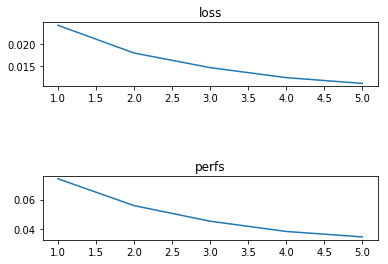

In [25]:
#24
print "B=50"
netminibatch = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=50)
y_resMini = forwardprop_shallow(xtest, netminibatch)
print "test loss:", eval_loss(y_resMini, dtest)
print "test perfs:", eval_perfs(y_resMini, onehot2label(dtest))

B=200
train loss: 0.020284933437413874
train perfs: 0.06021666666666667
test loss: 0.020199950360368136
test perfs: 0.0584


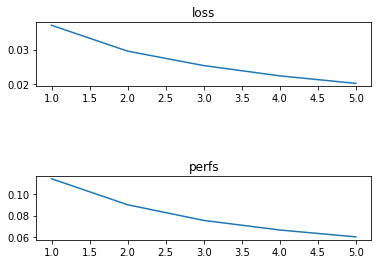

In [26]:
print "B=200"
netminibatch = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=200)
y_resMini = forwardprop_shallow(xtest, netminibatch)
print "test loss:", eval_loss(y_resMini, dtest)
print "test perfs:", eval_perfs(y_resMini, onehot2label(dtest))

train loss: 0.007970899835147642
train perfs: 0.025366666666666666
test loss: 0.010795551024120796
test perfs: 0.0326


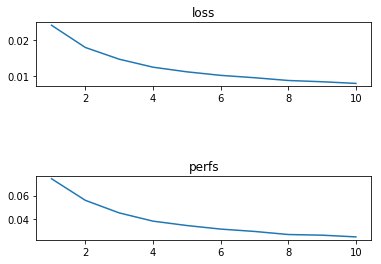

In [27]:
#25
#T=10
netminibatch = backprop_minibatch_shallow(xtrain, dtrain, netinit, 10, B=50)
y_resMini = forwardprop_shallow(xtest, netminibatch)
print "test loss:", eval_loss(y_resMini, dtest)
print "test perfs:", eval_perfs(y_resMini, onehot2label(dtest))


train loss: 0.00032175570800443396
train perfs: 0.0004
test loss: 0.012053180527269058
test perfs: 0.0246


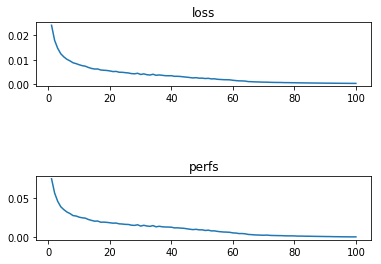

In [28]:
#T=100
netminibatch = backprop_minibatch_shallow(xtrain, dtrain, netinit, 100, B=50)
y_resMini = forwardprop_shallow(xtest, netminibatch)
print "test loss:", eval_loss(y_resMini, dtest)
print "test perfs:", eval_perfs(y_resMini, onehot2label(dtest))